In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
/Users/camille/.virtualenvs/supelec/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0, data_without_noise=False):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_with_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    if data_without_noise:
        return imdata_with_noise, imdata
    return imdata_with_noise

def generate_a_rectangle(noise=0.0, free_location=False, data_without_noise=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise, data_without_noise)


def generate_a_disk(noise=0.0, free_location=False, data_without_noise=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise, data_without_noise)

def generate_a_triangle(noise=0.0, free_location=False, data_without_noise=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    if data_without_noise:
        imdata, imdata_without_noise = generate_a_drawing(figsize, U, V, noise, data_without_noise)
        return [imdata, imdata_without_noise, [U[0], V[0], U[1], V[1], U[2], V[2]]]
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, num_classes=3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

def generate_dataset_image_denoising(nb_samples=300, noise_max_level=50):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X_with_noise = np.zeros([nb_samples,im_size])
    X_without_noise = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = np.random.rand()*noise_max_level
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X_with_noise[i], X_without_noise[i] = generate_a_rectangle(noise, free_location=True, data_without_noise=True)
        elif category == 1: 
            X_with_noise[i], X_without_noise[i] = generate_a_disk(noise, free_location=True, data_without_noise=True)
        else:
            [X_with_noise[i], X_without_noise[i], V] = generate_a_triangle(noise, free_location=True, data_without_noise=True)
    return [X_with_noise, X_without_noise]

## 3. Simple Classification

This part we will be dedicated to the choice of an optimization algorithm. We will compare the performances of Stochastic Gradient Descent algorithm to Adam algorithm on the simplest classifier. Indeed we will train a linear classifier (a dense layer with dimensions input_size*3 with softmax activation) directly on the input data.

The training dataset will be made of 300 noisy centered samples. See below some examples.

In [3]:
x_centered_samples, y_centered_samples = generate_dataset_classification(300, 20)
input_shape = x_centered_samples[0].shape[0]
y_centered_samples = keras.utils.to_categorical(y_centered_samples, num_classes=3)

Creating data:
0
100
200


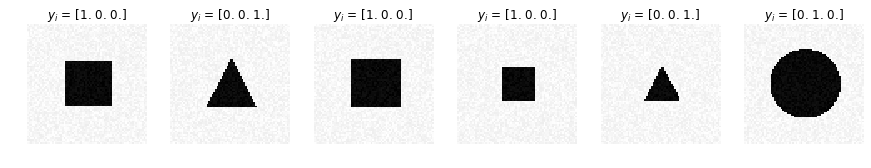

In [4]:
n_sample = 6
fig, ax = plt.subplots(1, n_sample, figsize=(15, 5))
for i in range(n_sample):
    ax[i].imshow(x_centered_samples[i].reshape((IMAGE_SIZE, -1)), cmap='gray')
    ax[i].set_title(f'$y_i$ = {y_centered_samples[i]}')
    ax[i].axis('off')

### 3.1 Selection of an optimization algorithm

In [5]:
def test_optimizer(optimizer, x_train=x_centered_samples, y_train=y_centered_samples, n_run=5, n_epoch=10):
    np.random.seed(12345)
    trained_models = [Sequential([Dense(3, activation='softmax', input_dim=input_shape)]) for i in range(n_run)]
    training_loss = np.zeros((n_run, n_epoch))
    for i, model in enumerate(trained_models):
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        model.fit(x_train, y_train, epochs=n_epoch, batch_size=32)
    return trained_models

n_run = 5
n_epoch = 30
sgd_optimizer = keras.optimizers.SGD(lr=10**(-3), momentum=0.0, decay=0.0, nesterov=False)
sgd_trained_models = test_optimizer(optimizer=sgd_optimizer, n_run=n_run, n_epoch=n_epoch)
adam_trained_models = test_optimizer(optimizer='adam', n_run=n_run, n_epoch=n_epoch)
sgd_training_loss = np.zeros((n_run, n_epoch))
adam_training_loss = np.zeros((n_run, n_epoch))
for i in range(n_run):
    sgd_training_loss[i, :] = sgd_trained_models[i].history.history['loss']
    adam_training_loss[i, :] = adam_trained_models[i].history.history['loss']

Epoch 1/30
300/300 [==============================] - 0s 430us/step - loss: 1.0623 - acc: 0.5133
Epoch 2/30
300/300 [==============================] - 0s 51us/step - loss: 0.9517 - acc: 0.5833
Epoch 3/30
300/300 [==============================] - 0s 61us/step - loss: 0.8662 - acc: 0.6867
Epoch 4/30
300/300 [==============================] - 0s 86us/step - loss: 0.8094 - acc: 0.6967
Epoch 5/30
300/300 [==============================] - 0s 75us/step - loss: 0.8016 - acc: 0.6800
Epoch 6/30
300/300 [==============================] - 0s 66us/step - loss: 0.7428 - acc: 0.7267
Epoch 7/30
300/300 [==============================] - 0s 62us/step - loss: 0.7002 - acc: 0.7533
Epoch 8/30
300/300 [==============================] - 0s 88us/step - loss: 0.6574 - acc: 0.8133
Epoch 9/30
300/300 [==============================] - 0s 88us/step - loss: 0.6582 - acc: 0.7467
Epoch 10/30
300/300 [==============================] - 0s 76us/step - loss: 0.6146 - acc: 0.8233
Epoch 11/30
300/300 [=================

300/300 [==============================] - 0s 63us/step - loss: 0.4405 - acc: 0.9067
Epoch 26/30
300/300 [==============================] - 0s 70us/step - loss: 0.4470 - acc: 0.9067
Epoch 27/30
300/300 [==============================] - 0s 77us/step - loss: 0.4340 - acc: 0.8767
Epoch 28/30
300/300 [==============================] - 0s 68us/step - loss: 0.4229 - acc: 0.9067
Epoch 29/30
300/300 [==============================] - 0s 54us/step - loss: 0.4190 - acc: 0.8867
Epoch 30/30
300/300 [==============================] - 0s 75us/step - loss: 0.4063 - acc: 0.9033
Epoch 1/30
300/300 [==============================] - 0s 443us/step - loss: 1.0596 - acc: 0.4400
Epoch 2/30
300/300 [==============================] - 0s 51us/step - loss: 1.0671 - acc: 0.4633
Epoch 3/30
300/300 [==============================] - 0s 71us/step - loss: 0.9047 - acc: 0.5833
Epoch 4/30
300/300 [==============================] - 0s 75us/step - loss: 0.8718 - acc: 0.6000
Epoch 5/30
300/300 [=========================

300/300 [==============================] - 0s 74us/step - loss: 0.0733 - acc: 0.9967
Epoch 20/30
300/300 [==============================] - 0s 76us/step - loss: 0.0655 - acc: 1.0000
Epoch 21/30
300/300 [==============================] - 0s 70us/step - loss: 0.0654 - acc: 1.0000
Epoch 22/30
300/300 [==============================] - 0s 69us/step - loss: 0.0659 - acc: 0.9967
Epoch 23/30
300/300 [==============================] - 0s 73us/step - loss: 0.0582 - acc: 1.0000
Epoch 24/30
300/300 [==============================] - 0s 68us/step - loss: 0.0555 - acc: 1.0000
Epoch 25/30
300/300 [==============================] - 0s 71us/step - loss: 0.0757 - acc: 0.9900
Epoch 26/30
300/300 [==============================] - 0s 66us/step - loss: 0.0778 - acc: 0.9900
Epoch 27/30
300/300 [==============================] - 0s 71us/step - loss: 0.0631 - acc: 1.0000
Epoch 28/30
300/300 [==============================] - 0s 66us/step - loss: 0.0487 - acc: 1.0000
Epoch 29/30
300/300 [=====================

300/300 [==============================] - 0s 63us/step - loss: 0.1521 - acc: 0.9733
Epoch 14/30
300/300 [==============================] - 0s 58us/step - loss: 0.1212 - acc: 0.9833
Epoch 15/30
300/300 [==============================] - 0s 66us/step - loss: 0.1226 - acc: 0.9867
Epoch 16/30
300/300 [==============================] - 0s 71us/step - loss: 0.0997 - acc: 0.9967
Epoch 17/30
300/300 [==============================] - 0s 73us/step - loss: 0.0898 - acc: 1.0000
Epoch 18/30
300/300 [==============================] - 0s 70us/step - loss: 0.0885 - acc: 1.0000
Epoch 19/30
300/300 [==============================] - 0s 69us/step - loss: 0.0918 - acc: 0.9967
Epoch 20/30
300/300 [==============================] - 0s 69us/step - loss: 0.0837 - acc: 0.9933
Epoch 21/30
300/300 [==============================] - 0s 67us/step - loss: 0.0755 - acc: 1.0000
Epoch 22/30
300/300 [==============================] - 0s 69us/step - loss: 0.0694 - acc: 1.0000
Epoch 23/30
300/300 [=====================

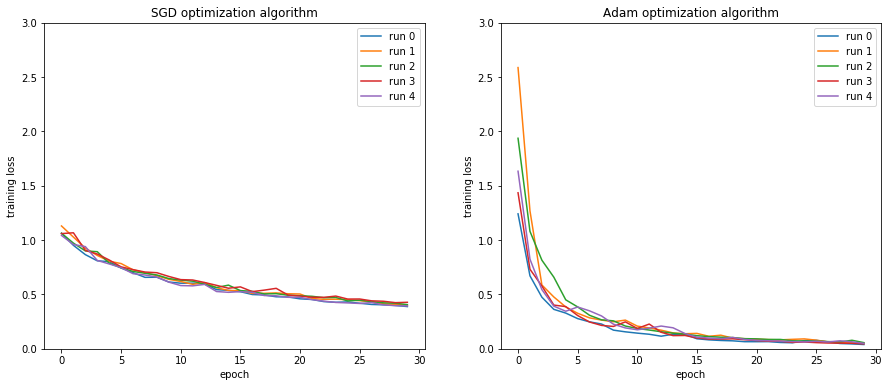

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
y_lim = (0, 3)
for i_plot, algorithm, training_loss in zip([0, 1], ['SGD', 'Adam'], [sgd_training_loss, adam_training_loss]):
    for i_run in range(n_run):
        _ = ax[i_plot].plot(training_loss[i_run, :], label=f'run {i_run}')
    _ = ax[i_plot].set_ylim(y_lim)
    _ = ax[i_plot].set_xlabel('epoch')
    _ = ax[i_plot].set_ylabel('training loss')
    _ = ax[i_plot].set_title(f'{algorithm} optimization algorithm')
    _ = ax[i_plot].legend()

#### Conclusion
 
With those 5 runs we can verify that convergence with Adam method is faster. Besides the default values of his hyperparameters ($\alpha, \beta_1, \text{and } \beta_2$) don't seem to require any finetuning unlike SGD algorithm. The convergence of the latter is highly sensitive to the learning rate's value among others.

We will only use Adam optimizer for the rest of this assignment.

### 3.2 Basic test of the linear classifier

In [7]:
n_sample = 5
np.random.seed(12345)
x_centered_samples_, y_centered_samples_ = generate_dataset_classification(n_sample, 20)
y_centered_samples_ = keras.utils.to_categorical(y_centered_samples_, num_classes=3)
model = adam_trained_models[0]
predictions = model.predict(x_centered_samples_)
predictions = np.round(predictions, 2)

Creating data:
0


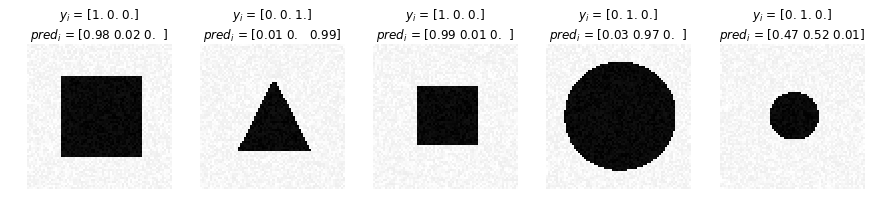

In [8]:
fig, ax = plt.subplots(1, n_sample, figsize=(15, 5))
for i in range(n_sample):
    ax[i].imshow(x_centered_samples_[i].reshape((IMAGE_SIZE, -1)), cmap='gray')
    ax[i].set_title(f'$y_i$ = {y_centered_samples_[i]}\n$pred_i$ = {predictions[i]}')
    ax[i].axis('off')

#### Conclusion
 
On this first problem simple (noise but centered drawings) the linear classifier happens to perform well. 

## 4. Visualization of the weights

In that part we will try to provide an interpretation of the weights of the linear classifier trained with adam optimizer.

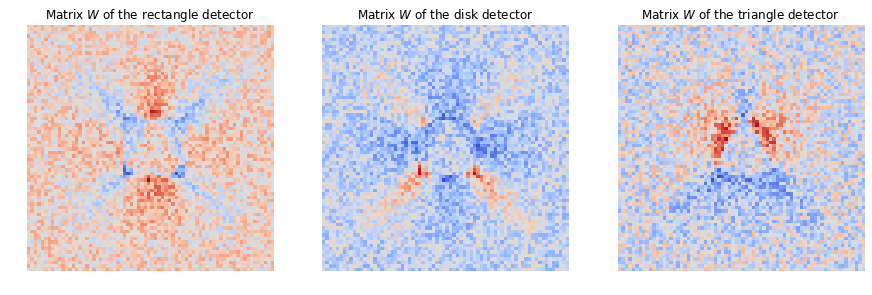

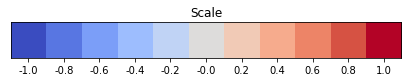

In [9]:
w = adam_trained_models[0].get_weights()[0]
w = w.reshape((IMAGE_SIZE, -1, 3))
labels = ['rectangle', 'disk', 'triangle']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    _ = ax[i].imshow(w[:, :, i], cmap='coolwarm')
    _ = ax[i].set_title(f'Matrix $W$ of the {labels[i]} detector')
    ax[i].axis('off')
    
fig, ax = plt.subplots(1, 1, figsize=(7, 1))
scale = np.arange(-1 ,1.1, 0.2)
_ = ax.imshow(scale.reshape((1, -1)), cmap='coolwarm')
_ = ax.set_title('Scale')
_ = ax.set_xticks(np.arange(scale.shape[0]))
_ = ax.set_xticklabels(map(str, np.round(scale, 2).tolist()))
_ = ax.set_yticks([])
_ = ax.set_yticklabels([])

#### Interpretation

Since we don't have any hidden layer the interpretation of the weights is made easier. The decision function of each neuron is a simple weighted sum over the pixels' intensity (the bias are almost zeros). However, one must remind that the shapes are black while the rest of the image is white. Hence the decision isn't made on the shape itself but on its complementary area. 

Weights can be grouped in 3 categories:
- the ones that are not involved in the decision (the gray ones)
- the ones that are react positively to a white pixel (the ones in red)
- the ones that are react negatively to a white pixel (the ones in blue)

Based on the balance between the last two groups a decision is taken for each shape by its corresponding neuron.

## 5. A more difficult classification problem

Here we will address a more challenging classification problem. From now one the shapes will allowed to have a free location in the image.

In [10]:
np.random.seed(12345)
x_train_free_loc, y_train_free_loc = generate_dataset_classification(10**3, 20, True)
y_train_free_loc = keras.utils.to_categorical(y_train_free_loc, num_classes=3)
x_test_free_loc, y_test_free_loc = generate_test_set_classification()

Creating data:
0
100
200
300
400
500
600
700
800
900
Creating data:
0
100
200


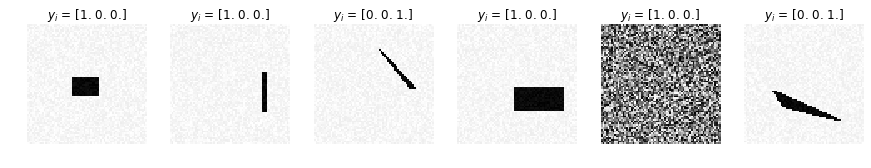

In [11]:
n_sample = 6
fig, ax = plt.subplots(1, n_sample, figsize=(15, 5))
for i in range(n_sample):
    ax[i].imshow(x_train_free_loc[i].reshape((IMAGE_SIZE, -1)), cmap='gray')
    ax[i].set_title(f'$y_i$ = {y_train_free_loc[i]}')
    ax[i].axis('off')

#### Linear classifier

In [12]:
np.random.seed(12345)
n_run = 3
n_epoch = 15
linear_classifiers = [Sequential([Dense(3, activation='softmax', input_dim=input_shape)]) for i in range(n_run)]
linear_classifiers_accuracy = np.zeros(n_run)
linear_classifiers_training_loss = np.zeros((n_run, n_epoch))
for i, model in enumerate(linear_classifiers):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_free_loc, y_train_free_loc, epochs=n_epoch, batch_size=32)
    linear_classifiers_training_loss[i, :] = history.history['loss']
    _, linear_classifiers_accuracy[i] = model.evaluate(x_test_free_loc, y_test_free_loc)

Epoch 1/15
1000/1000 [==============================] - 0s 333us/step - loss: 1.8441 - acc: 0.3370
Epoch 2/15
1000/1000 [==============================] - 0s 50us/step - loss: 1.0734 - acc: 0.4370
Epoch 3/15
1000/1000 [==============================] - 0s 49us/step - loss: 0.9469 - acc: 0.5140
Epoch 4/15
1000/1000 [==============================] - 0s 49us/step - loss: 0.9676 - acc: 0.5420
Epoch 5/15
1000/1000 [==============================] - 0s 50us/step - loss: 0.9483 - acc: 0.5340
Epoch 6/15
1000/1000 [==============================] - 0s 50us/step - loss: 0.8549 - acc: 0.5950
Epoch 7/15
1000/1000 [==============================] - 0s 49us/step - loss: 0.8568 - acc: 0.5760
Epoch 8/15
1000/1000 [==============================] - 0s 49us/step - loss: 0.8959 - acc: 0.5780
Epoch 9/15
1000/1000 [==============================] - 0s 51us/step - loss: 0.9989 - acc: 0.5490
Epoch 10/15
1000/1000 [==============================] - 0s 50us/step - loss: 0.9454 - acc: 0.5480
Epoch 11/15
1000/1

#### Neural network with convolutional layers

In [13]:
x_train_free_loc_ = x_train_free_loc.reshape((-1, 72, 72, 1))
x_test_free_loc_ = x_test_free_loc.reshape((-1, 72, 72, 1))

In [14]:
np.random.seed(12345)
n_run = 3
n_epoch = 15
cnn = [Sequential([
        keras.layers.Conv2D(filters=16, kernel_size=(5,5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=16, kernel_size=(3,3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu'),
        Flatten(),
        Dense(3, activation='softmax')
    ]) for i in range(n_run)]
cnn_test_accuracy = np.zeros(n_run)
cnn_training_loss = np.zeros((n_run, n_epoch))
for i, model in enumerate(cnn):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_free_loc_, y_train_free_loc, epochs=n_epoch, batch_size=32)
    cnn_training_loss[i, :] = history.history['loss']
    _, cnn_test_accuracy[i] = model.evaluate(x_test_free_loc_, y_test_free_loc)

Epoch 1/15
1000/1000 [==============================] - 2s 2ms/step - loss: 1.0575 - acc: 0.4820
Epoch 2/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7914 - acc: 0.6500
Epoch 3/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6855 - acc: 0.7040
Epoch 4/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5941 - acc: 0.7410
Epoch 5/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5546 - acc: 0.7750
Epoch 6/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4529 - acc: 0.8270
Epoch 7/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3754 - acc: 0.8730
Epoch 8/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2729 - acc: 0.9160
Epoch 9/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2273 - acc: 0.9220
Epoch 10/15
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1715 - acc: 0.9560
Epoch 11/15
1000/1000 [======

#### Training loss

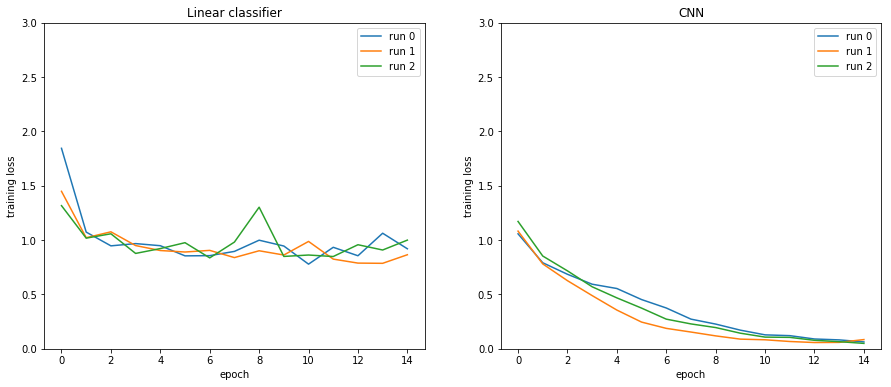

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
y_lim = (0, 3)
for i_plot, model, training_loss in zip([0, 1], ['Linear classifier', 'CNN'], [linear_classifiers_training_loss, cnn_training_loss]):
    for i_run in range(n_run):
        _ = ax[i_plot].plot(training_loss[i_run, :], label=f'run {i_run}')
    _ = ax[i_plot].set_ylim(y_lim)
    _ = ax[i_plot].set_xlabel('epoch')
    _ = ax[i_plot].set_ylabel('training loss')
    _ = ax[i_plot].set_title(f'{model}')
    _ = ax[i_plot].legend()

#### Test accuracy

In [16]:
lc_pred = linear_classifiers[0].predict(x_test_free_loc)
cnn_pred = cnn[0].predict(x_test_free_loc_)
lc_confusion_matrix = confusion_matrix(np.argmax(y_test_free_loc, axis=1), np.argmax(lc_pred, axis=1))
lc_accuracy_per_class = np.divide(lc_confusion_matrix, np.sum(lc_confusion_matrix, axis=0)).reshape(-1)[::4]
cnn_confusion_matrix = confusion_matrix(np.argmax(y_test_free_loc, axis=1), np.argmax(cnn_pred, axis=1))
cnn_accuracy_per_class = np.divide(cnn_confusion_matrix, np.sum(cnn_confusion_matrix, axis=0)).reshape(-1)[::4]

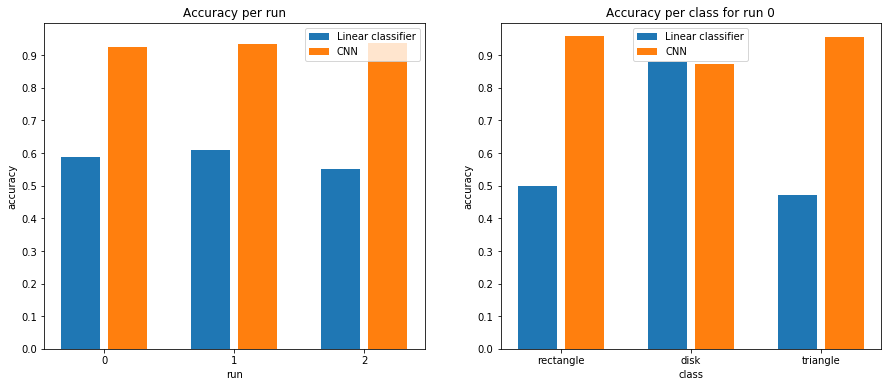

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
width = 0.3
y_lim = (0, 1)

# accuracy per run
for i_bar, model, test_accuracy in zip([0, 1], ['Linear classifier', 'CNN'], [linear_classifiers_accuracy, cnn_test_accuracy]):
    _ = ax[0].bar(x=np.arange(n_run) + (2*i_bar - 1)*0.6*width, height=test_accuracy, width=width, label=model)
_ = ax[0].set_ylim(y_lim)
_ = ax[0].set_xlabel('run')
_ = ax[0].set_xticks(range(n_run))
_ = ax[0].set_yticks(np.arange(0, 1., 0.1))
_ = ax[0].set_ylabel('accuracy')
_ = ax[0].set_title('Accuracy per run')
_ = ax[0].legend()

# accuracy per class
for i_bar, model, accuracy_per_class in zip([0, 1], ['Linear classifier', 'CNN'], [lc_accuracy_per_class, cnn_accuracy_per_class]):
    _ = ax[1].bar(x=np.arange(n_run) + (2*i_bar - 1)*0.6*width, height=accuracy_per_class, width=width, label=model)
_ = ax[1].set_ylim(y_lim)
_ = ax[1].set_xlabel('class')
_ = ax[1].set_xticks(range(3))
_ = ax[1].set_xticklabels(['rectangle', 'disk', 'triangle'])
_ = ax[1].set_yticks(np.arange(0, 1., 0.1))
_ = ax[1].set_ylabel('accuracy')
_ = ax[1].set_title('Accuracy per class for run 0')
_ = ax[1].legend()

#### Conclusion

The linear classifier performs very poorly on the free location classification problem. For some reason it's not bad at recognizing disks. But with triangles and rectangles its performances aren't satisfying bearing in mind that random guessing would lead to 0.33% accuracy.

On the other hand the convolutional neural network performs quite well without any need to tune it.

## 6. A regression problem

The main difficulty of that regression problem is to correctly label the vertices. In other words, we must find a way to map every triangle to a unique set of coordinates $(x_1, y_1, x_2, y_2, x_3, y_3)$. 

What we suggest is to always label the bottom-right vertex as the first one and to label the two others by turning anti-clockwise. When such a bottom right vertex doesn't exist but we have an isolated top-right vertex, we will label as one the rightmost bottom vertex.

In [18]:
x_train_reg, y_train_reg = generate_dataset_regression(10**3, 20)
x_test_reg, y_test_reg = generate_test_set_regression()

Creating data:
0
100
200
300
400
500
600
700
800
900
Creating data:
0
100
200


In [19]:
def sort_vertexes(y_data):
    x = y_data[:, ::2]
    y = y_data[:, 1::2]
    x_barycentre = np.mean(x, axis=1).reshape((-1, 1))
    y_barycentre = np.mean(y, axis=1).reshape((-1, 1))
    x_diff = np.subtract(x, x_barycentre)
    y_diff = np.subtract(y, y_barycentre)
    d = (x_diff**2 + y_diff**2)**0.5
    cos_theta = np.divide(x_diff, d)
    sin_theta = np.divide(y_diff, d)
    theta = np.arctan(np.divide(sin_theta, cos_theta))
    theta[cos_theta < 0] += np.pi
    theta = (theta+np.pi/2)*(360/(2*np.pi))
    
    x_sorted = np.zeros(x.shape)
    y_sorted = np.zeros(x.shape)
    theta_sorted = np.zeros(x.shape)
    label = (np.ones(x.shape)*np.arange(1, 4)).astype(int)

    and_tmp = np.logical_and(np.sum(x_diff > 0, axis=1).astype(int)==1, np.sum(y_diff > 0, axis=1).astype(int)==1)
    isolated_top_right_vertex = np.logical_and(and_tmp, np.sum(np.logical_and(x_diff > 0, y_diff > 0), axis=1)==1)
    order_isolated_vertex_tmp = np.argsort(theta[isolated_top_right_vertex], axis=1)
    order_isolated_vertex = np.concatenate([order_isolated_vertex_tmp[:, -1:], order_isolated_vertex_tmp[:,:-1]], axis=1)
    order_no_isolated_vertex = np.argsort(theta[~isolated_top_right_vertex], axis=1)
    order = np.zeros(x.shape)
    order[isolated_top_right_vertex] = order_isolated_vertex
    order[~isolated_top_right_vertex] = order_no_isolated_vertex
    order = order.astype(int)

    for i in range(x.shape[0]):
        x_sorted[i, :] = x[i, order[i, :]]
        y_sorted[i, :] = y[i, order[i, :]]
        theta_sorted[i, :] = theta[i, order[i, :]]
        
    y_data_sorted = np.zeros(y_data.shape)
    y_data_sorted[:, ::2] = x_sorted
    y_data_sorted[:, 1::2] = y_sorted
    return y_data_sorted

In [20]:
y_train_reg_sorted = sort_vertexes(y_train_reg)
y_test_reg_sorted = sort_vertexes(y_test_reg)
x_train_reg = x_train_reg.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
x_test_reg = x_test_reg.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))

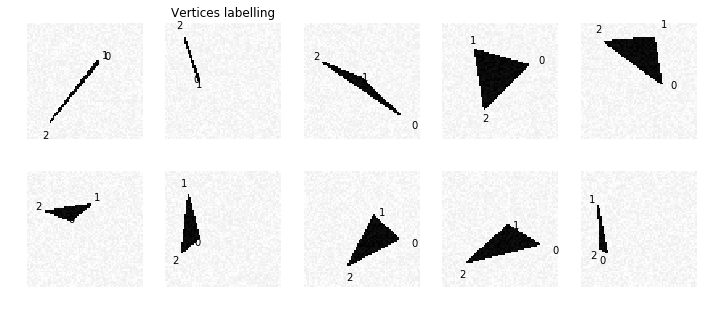

In [21]:
i_max = 2
j_max = 5
x_sorted = y_train_reg_sorted[:(i_max*j_max), ::2]
y_sorted = y_train_reg_sorted[:(i_max*j_max), 1::2]
fig, ax = plt.subplots(i_max, j_max, figsize=(12, 5))
for i in range(i_max):
    for j in range(j_max):
        ax[i, j].imshow(x_train_reg[i*j_max + j].reshape(IMAGE_SIZE, -1), cmap='gray')
        ax[i, j].axis('off')
        for k in range(3):
            ax[i, j].text(x=x_sorted[i*j_max + j, k]*IMAGE_SIZE+2, y=(IMAGE_SIZE-y_sorted[i*j_max + j, k]*IMAGE_SIZE)+2, s=str(k))
_ = ax[0, 1].set_title('Vertices labelling')

In [22]:
np.random.seed(1234)
n_run = 3
n_epoch = 15
cnn_trained_models = [Sequential([
        keras.layers.Conv2D(filters=3, kernel_size=(6, 6), strides=(2, 2), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(6, activation='relu')
    ]) for i in range(n_run)]
cnn_test_accuracy_ = np.zeros(n_run)
cnn_training_loss = np.zeros((n_run, n_epoch))
for i, model in enumerate(cnn_trained_models):
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
    history = model.fit(x_train_reg, y_train_reg_sorted, epochs=n_epoch, batch_size=32)
    cnn_training_loss[i, :] = history.history['loss']
    _, cnn_test_accuracy_[i] = model.evaluate(x_test_reg, y_test_reg_sorted)

Epoch 1/15
1000/1000 [==============================] - 1s 892us/step - loss: 0.2494 - mean_absolute_error: 0.2494
Epoch 2/15
1000/1000 [==============================] - 0s 431us/step - loss: 0.1895 - mean_absolute_error: 0.1895
Epoch 3/15
1000/1000 [==============================] - 0s 432us/step - loss: 0.1513 - mean_absolute_error: 0.1513
Epoch 4/15
1000/1000 [==============================] - 0s 434us/step - loss: 0.1394 - mean_absolute_error: 0.1394
Epoch 5/15
1000/1000 [==============================] - 0s 433us/step - loss: 0.1332 - mean_absolute_error: 0.1332
Epoch 6/15
1000/1000 [==============================] - 0s 428us/step - loss: 0.1288 - mean_absolute_error: 0.1288
Epoch 7/15
1000/1000 [==============================] - 0s 436us/step - loss: 0.1229 - mean_absolute_error: 0.1229
Epoch 8/15
1000/1000 [==============================] - 0s 434us/step - loss: 0.1199 - mean_absolute_error: 0.1199
Epoch 9/15
1000/1000 [==============================] - 0s 434us/step - loss: 0.

In [23]:
cnn_test_accuracy_

array([0.12900296, 0.16267659, 0.28330979])

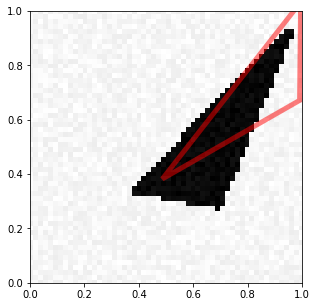

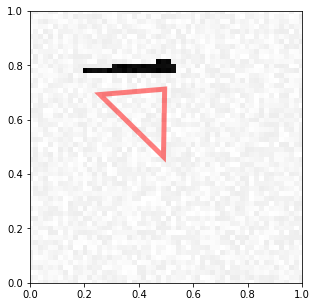

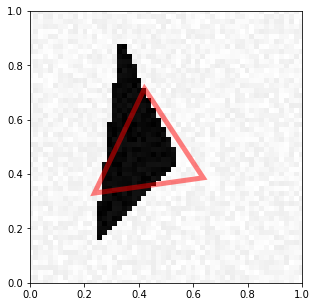

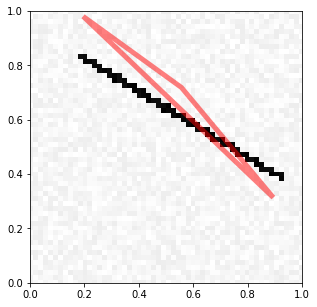

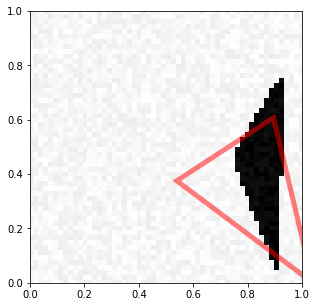

In [24]:
model = cnn_trained_models[0]
n_samples = 5
for k in range(n_samples):
   visualize_prediction(x_test_reg[k,:, :, 0], model.predict(x_test_reg[k:(k+1), :, :, :]))

#### Conclusion

The regression doesn't work well. It's very likely that it comes from the vertices labelling which prevent the network to reach good performances. 

## 7. Image denoising

The goal of this part is to design an hourglass network to denoise drawings.

In [25]:
x_with_noise, x_without_noise = generate_dataset_image_denoising(nb_samples=600, noise_max_level=100)

Creating data:
0
100
200
300
400
500


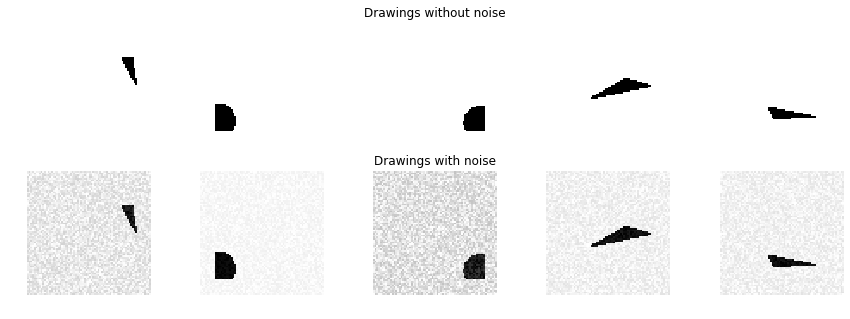

In [26]:
n_sample = 5
fig, ax = plt.subplots(2, n_sample, figsize=(15, 5))
for i in range(n_sample):
    ax[0, i].imshow(x_without_noise[i].reshape((IMAGE_SIZE, -1)), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(x_with_noise[i].reshape((IMAGE_SIZE, -1)), cmap='gray')
    ax[1, i].axis('off')
_ = ax[0, 2].set_title('Drawings without noise')
_ = ax[1, 2].set_title('Drawings with noise')

In [27]:
x_train_noise = x_with_noise[:300].reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
x_train_without_noise = x_without_noise[:300].reshape((-1, IMAGE_SIZE**2))
x_test_noise = x_with_noise[300:].reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
x_test_without_noise = x_without_noise[300:].reshape((-1, IMAGE_SIZE**2))

In [28]:
np.random.seed(1234)
n_epoch = 15
hour_glass_model = Sequential([
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu',  padding='same'),
    keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D(size=(2, 2)),
    keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
    Flatten()
])
hour_glass_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
hour_glass_model.fit(x_train_noise, x_train_without_noise, epochs=n_epoch, batch_size=32)

Epoch 1/15
300/300 [==============================] - 2s 5ms/step - loss: 10310824.0533 - acc: 1.0000
Epoch 2/15
300/300 [==============================] - 1s 3ms/step - loss: 10217870.8800 - acc: 1.0000
Epoch 3/15
300/300 [==============================] - 1s 3ms/step - loss: 10210015.8000 - acc: 1.0000
Epoch 4/15
300/300 [==============================] - 1s 3ms/step - loss: 10201131.0800 - acc: 1.0000
Epoch 5/15
300/300 [==============================] - 1s 3ms/step - loss: 10181455.7867 - acc: 1.0000
Epoch 6/15
300/300 [==============================] - 1s 3ms/step - loss: 10148613.7067 - acc: 1.0000
Epoch 7/15
300/300 [==============================] - 1s 3ms/step - loss: 10122226.0533 - acc: 0.9733
Epoch 8/15
300/300 [==============================] - 1s 3ms/step - loss: 10110971.2133 - acc: 0.9733
Epoch 9/15
300/300 [==============================] - 1s 3ms/step - loss: 10104584.0933 - acc: 1.0000
Epoch 10/15
300/300 [==============================] - 1s 3ms/step - loss: 1010234

In [29]:
hour_glass_model.evaluate(x_test_noise, x_test_without_noise)

300/300 [==============================] - 1s 2ms/step


[10108713.24, 1.0]

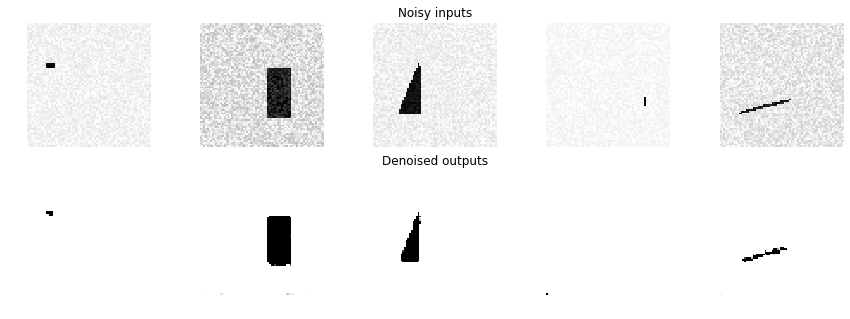

In [30]:
n_sample = 5
predictions = hour_glass_model.predict(x_test_noise.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1)))
fig, ax = plt.subplots(2, n_sample, figsize=(15, 5))
for i in range(n_sample):
    ax[0, i].imshow(x_test_noise[i].reshape((IMAGE_SIZE, -1)), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(predictions[i].reshape((IMAGE_SIZE, -1)), cmap='gray')
    ax[1, i].axis('off')
_ = ax[0, 2].set_title('Noisy inputs')
_ = ax[1, 2].set_title('Denoised outputs')

#### Conclusion

It's not that hard to train such a network. Many configurations seems to do the job properly. It's not straigthforward to find the smallest network (in terms of numbers of convolution layers for instance) that still performs well though. Yet this finetuning is important since it will not only impact on the training time but also on the denoising time.